# MCMC with Blackjax for Sparse Regression

Following the example in sparse_regression.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
import blackjax

tfd = tfp.distributions
jdc = tfp.distributions.JointDistributionCoroutineAutoBatched

rng = jax.random.PRNGKey(20230301)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Data Generation

In [3]:
M, N, alpha0, sigma0, sig_prob0 = 200, 100, 3.0, 1.0, 0.05

rng, key0, key1, key2, key3, key4, key5 = jax.random.split(rng, 7)
X = jax.random.normal(key0, (N, M))
beta0 = jax.random.normal(key1, (M,)) * 0.25
index = jax.random.uniform(key2, (M,)) <= 0.05
beta_replace = jax.random.normal(key3, (index.sum(),)) + 10 * jax.random.choice(
    key4, np.asarray([-1, 1]), (index.sum(),)
)
beta0 = beta0.at[index].set(beta_replace)
y = X @ beta0 + alpha0 + jax.random.normal(key5, (N,)) * sigma0


Text(0.5, 0, 'True Slopes')

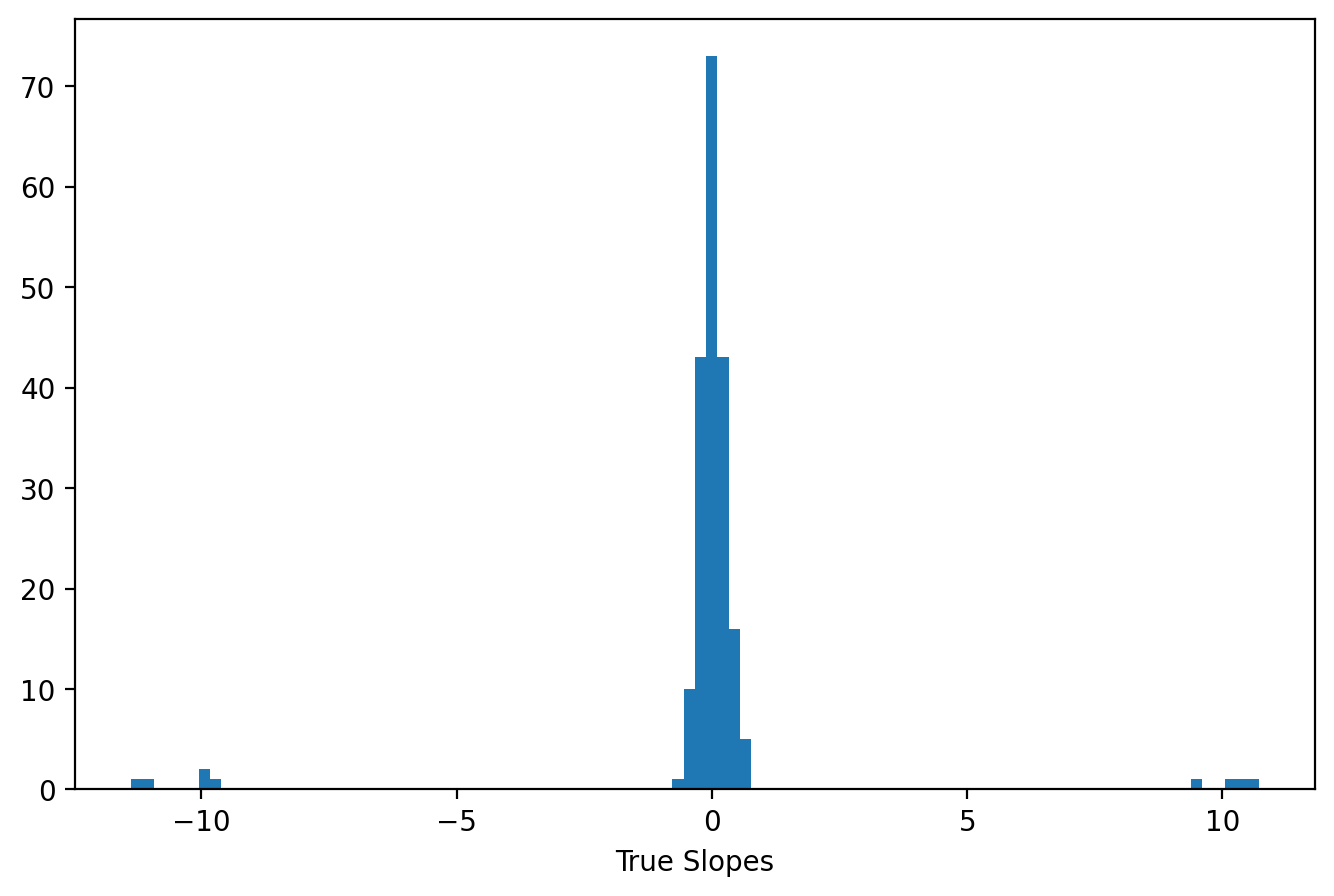

In [4]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(beta0, 100)
ax.set_xlabel("True Slopes")


## Plotting

In [5]:
# Some plotting functions
def plot_slope(beta_post, priorname, n_plot=200):
    beta_post = beta_post.reshape(-1, M).T
    _, ax = plt.subplots(1, 1, figsize=(8, 5))

    ax.step(
        np.arange(M), beta_post[:, -n_plot:], alpha=0.01, color="grey", linestyle="-"
    )
    ax.step(np.arange(M), beta_post.mean(axis=-1), color="r")
    ax.step(beta0, "k", alpha=0.5)
    ax.vlines(np.where(index == 1)[0] - 0.5, -15, 15, linestyle="--", alpha=0.5)
    ax.set_title(priorname)
    ax.set_xlabel("Slope Index")
    ax.set_ylabel("Slope Posterior")
    return ax


In [6]:
def plot_slope_diff(beta_post, priorname, n_plot=200):
    beta_post = beta_post.reshape(-1, M).T
    _, ax = plt.subplots(1, 1, figsize=(8, 5))

    ax.step(
        np.arange(M),
        beta_post[:, -n_plot:] - beta0[..., None],
        alpha=0.01,
        color="grey",
        linestyle="-",
    )
    ax.step(
        np.arange(M),
        beta_post.mean(axis=-1, keepdims=True) - beta0[..., None],
        color="r",
    )
    ax.hlines(0, 0, M, colors="k", alpha=0.5)
    ax.vlines(np.where(index == 1)[0] - 0.5, -15, 15, linestyle="--", alpha=0.5)
    ax.set_title(priorname)
    ax.set_xlabel("Slope Index")
    ax.set_ylabel("Slope Posterior")
    return ax


## Model generation function

In [7]:
def get_joint_logdensity(pinned_model):
    # Get the default change of variable bijectors from the model
    bijectors = pinned_model.experimental_default_event_space_bijector()

    def joint_logdensity(unbound_param):
        param = bijectors.forward(unbound_param)
        log_det_jacobian = bijectors.forward_log_det_jacobian(unbound_param)
        return pinned_model.unnormalized_log_prob(param) + log_det_jacobian

    return joint_logdensity, bijectors


In [8]:
def regression_model(design_matrix, beta_dist=tfd.Normal, **beta_kwargs):
    @jdc
    def model():
        intercept = yield tfd.Normal(0.0, 2.0, name="intercept")
        sigma = yield tfd.HalfNormal(2.0, name="sigma")
        beta = yield tfd.Sample(beta_dist(**beta_kwargs), M, name="beta")
        yhat = design_matrix @ beta + intercept
        yield tfd.Normal(yhat, sigma, name="y")

    return model


In [9]:
# wide_normal_model = regression_model(X, tfd.Normal, loc=0.0, scale=10.0)
# narrow_normal_model = regression_model(X, tfd.Normal, loc=0.0, scale=1.0)

# laplace_model = regression_model(X, tfd.Laplace, loc=0.0, scale=1.0)


## Composable Inference in Blackjax

Breaking down window adaptation

In [10]:
# Model that is difficult to sample with standard routine (window adaptation NUTS)
horseshoe_model = regression_model(X, tfd.Horseshoe, scale=1.0)

pinned_model = horseshoe_model.experimental_pin(y=y)
rng, init_key, sample_key = jax.random.split(rng, 3)
init_params = pinned_model.sample_unpinned(seed=init_key)
joint_logdensity, bijectors = get_joint_logdensity(pinned_model)


In [11]:
from functools import partial
from jax.flatten_util import ravel_pytree

# Initialize the state
state = blackjax.mcmc.nuts.init(init_params, joint_logdensity)
# Low level NUTS API
nuts_onestep_ = blackjax.mcmc.nuts.kernel()
nuts_onestep = jax.jit(partial(nuts_onestep_, logdensity_fn=joint_logdensity))
tuneable_params = dict(
    step_size=1e-3, inverse_mass_matrix=jnp.ones_like(ravel_pytree(init_params)[0])
)
# one iteration of NUTS sampler
next_state, info = nuts_onestep(sample_key, state, **tuneable_params)


In [12]:
jax.tree_map(jnp.shape, state)


HMCState(position=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
), logdensity=(), logdensity_grad=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
))

In [13]:
jax.tree_map(jnp.shape, info)


NUTSInfo(momentum=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
), is_divergent=(), is_turning=(), energy=(), trajectory_leftmost_state=IntegratorState(position=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
), momentum=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
), logdensity=(), logdensity_grad=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
)), trajectory_rightmost_state=IntegratorState(position=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
), momentum=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
), logdensity=(), logdensity_grad=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
)), num_trajectory_expansions=(), num_integration_steps=(), acceptance_rate=())

(-0.0025, 0.0025)

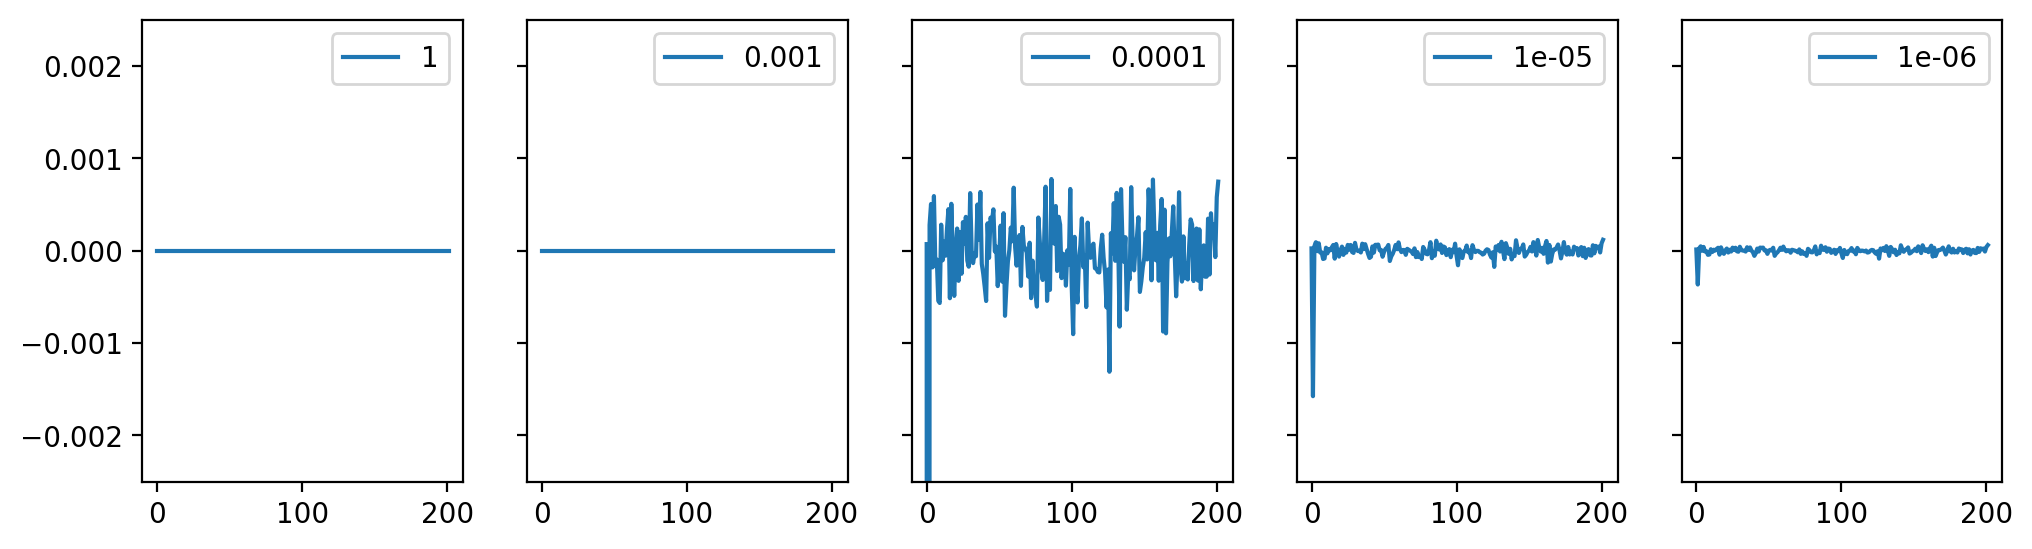

In [14]:
_, axes = plt.subplots(1, 5, figsize=(12, 3), sharey=True)
for (step_size, ax) in zip([1, 1e-3, 1e-4, 1e-5, 1e-6], axes):
    tuneable_params["step_size"] = step_size
    next_state, info = nuts_onestep(sample_key, state, **tuneable_params)

    flatten_state0 = ravel_pytree(state.position)[0]
    flatten_state1 = ravel_pytree(next_state.position)[0]
    ax.plot(flatten_state0 - flatten_state1, label=step_size)
    ax.legend()
ax.set_ylim(-0.0025, 0.0025)


In [15]:
from blackjax.adaptation.step_size import dual_averaging_adaptation

da_init, da_update, da_final = dual_averaging_adaptation(target=0.8)
da_state = da_init(inital_step_size=1.0)


In [16]:
step_size_hist = [jnp.exp(da_state.log_step_size)]

for i in range(100):
    rng, sample_key = jax.random.split(rng)
    # Sampling
    tuneable_params["step_size"] = jnp.exp(da_state.log_step_size)
    state, info = nuts_onestep(sample_key, state, **tuneable_params)
    # Tuning
    da_state = jax.jit(da_update)(da_state, info.acceptance_rate)
    # Logging
    step_size_hist.append(jnp.exp(da_state.log_step_size))


0.0011539543


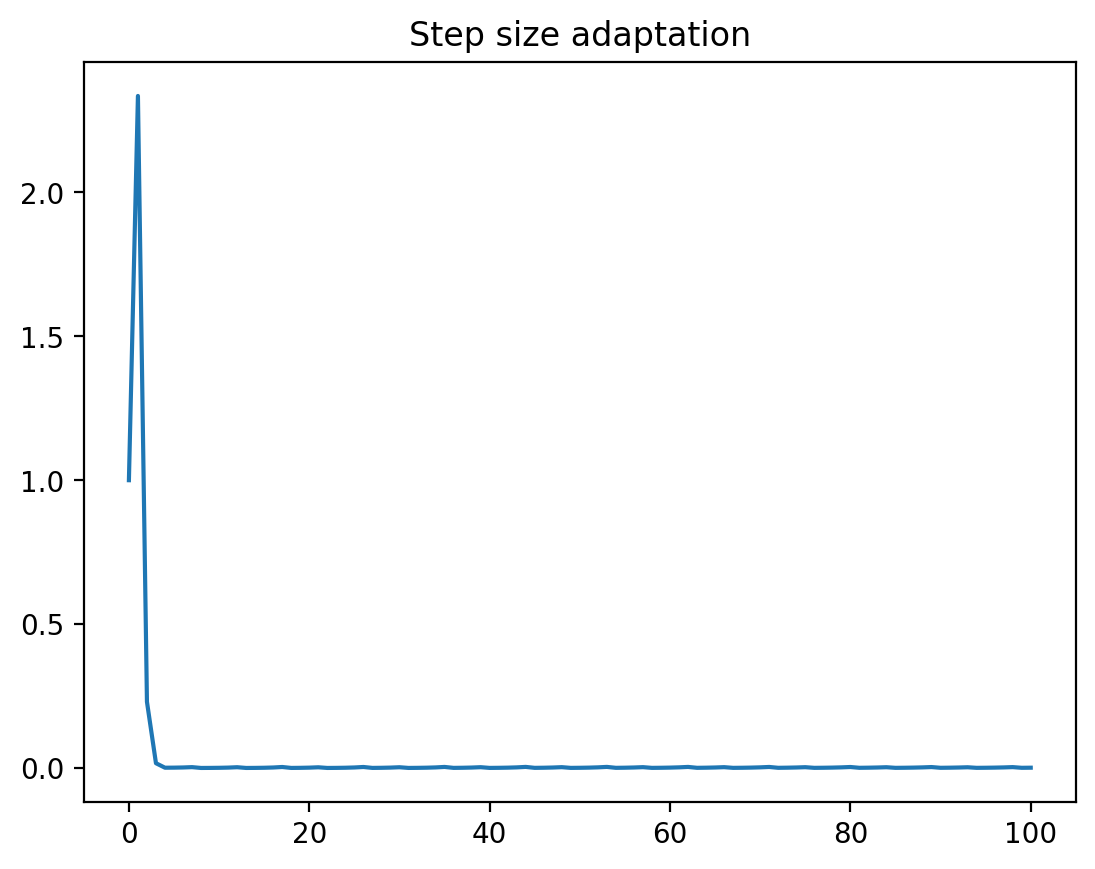

In [17]:
plt.plot(step_size_hist)
plt.title("Step size adaptation")
print(np.mean(step_size_hist[-10]))


Text(0.5, 1.0, 'Change in beta between initial and after step size adaptation')

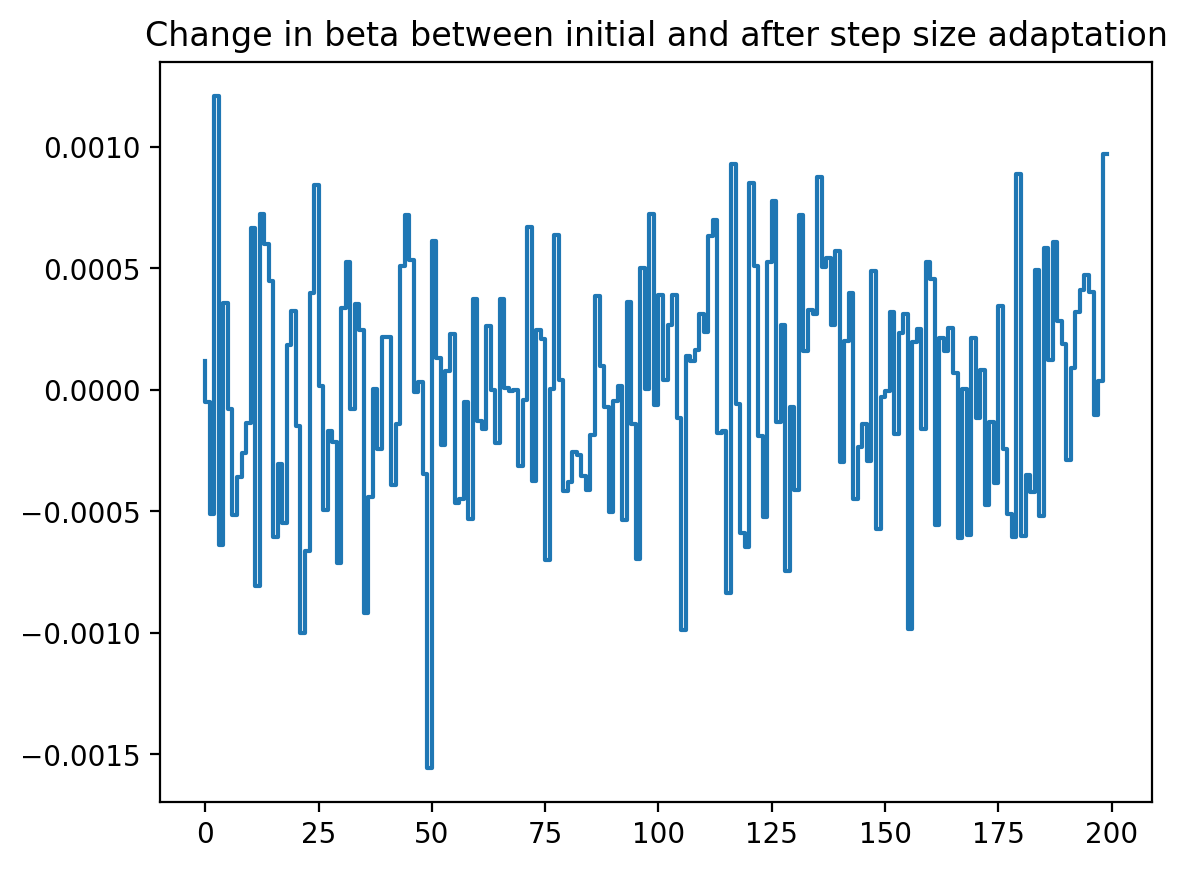

In [18]:
plt.step(np.arange(M), init_params.beta - state.position.beta)
plt.title("Change in beta between initial and after step size adaptation")
# plt.step(np.arange(M), beta0, color='r')


```python
# Signature of MCMC kernel one step function
def mcmc_kernel_onestep(
        random_key, sampler_state: State, **tuneable_params
        ) -> (State, SamplerInfo):

# Signature of MCMC parameter tuning function
def tuning_onestep(
        tuning_state: TuningState, sampler_info: SamplerInfo
        ) -> (TuningState, TuningInfo):

# Signature of MCMC with tuning
for ...:
    # Sampling
    sampler_state, sampler_info = mcmc_kernel_onestep(...)
    # Tuning
    tuning_state, tuning_info = tuning_onestep(...)
    # More Tuning
    ...

# Scheduling of MCMC parameter update
blackjax.adaptation.window_adaptation.schedule(num_steps=n_warmup)

```